In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


In [2]:
# Useful Abstractions
def dagger(A:np.array):
    return A.conj().T

def mult_kron(mats:list):
    if not mats:
        raise ValueError("Need at least one matrix")
    result = mats[0]
    for m in mats[1:]:
        result = np.kron(result, m)
    return result

def normalize_array(A:np.array):
    return A/np.linalg.norm(A)

# Building the Hamiltonian for large systems
We now can try to describe a concrete example. Before doing this we need to be able to build Hamiltonians  and learn how to diagonalize it 
Fist build a $2^N\times  2^N$ Hermitian matrix. (E.g. set N=2), the idea is to use np.random.rand to create a random matrix and then make it Hermitian by adding its conjugate transpose. Use np.conj and np.transpose to build the conjugate transpose of a matrix. 
Then use np.linalg.eig to diagonalize it, check that the eigenvalues and eigenvectors satisfy the equation, make use of the documentation of numpy package you find online.

In [3]:
def create_rand_hamiltonian(N:int=2):
    random_square_matrix = np.random.rand(N,N)
    hermitian_matrix = (random_square_matrix + dagger(random_square_matrix)) * 0.5
    return hermitian_matrix

M = create_rand_hamiltonian()

# Check if it is hermitian
np.allclose(M,M.conj().T)

True

## Eigenvectors
Now you can diagonalize it, and extract eigenvectors and eigenvalues, check that you can get back the original matrix 
$M = U m U^{\dagger}$

and that 
$M\vec{u}_1 = m_1 \vec{u}_1$
Here the functions you need are np.linalg.eig and np.allclose, remember that the eigenvalues are not necesarrily ordered,thought they might if the matrix is small enough and Hermitian. Also remember that the eigenvectors are columns of U.


In [4]:
# Diagonalization
m,U = la.eigh(M)
M_recon = U @ np.diag(m) @ dagger(U)
np.allclose(M,M_recon)

True

In [5]:
# Check an eigenpair
i = 0
np.allclose(M @ U[:, i], m[i] * U[:, i])

True

## Local Hamiltonian
Now we can study our first many body system, the Ising model in transverse field for  N=3
  spins, the Hamiltonian reads  H=−σ1x⊗σ2x−σ2x⊗σ3x−σ3x⊗σ1x+λ(σ1z+σ2z+σ3z)
 , build it for several values of  λ
  (e.g. 20 points in the interval  [0,10]
 ) and plot the ground state energy for every value.

 Notice we are considreing periodic boundary conditions here, so the last term connects the first and last spin.

 In order to build the Hamiltonian you can use the np.kron function to build the tensor product of two matrices, and the np.eye function to build identity matrices of size 2. For example σ1x⊗σ2x can be built as np.kron(np.kron(sigma_x,sigma_x),np.eye(2)) where sigma_x is the Pauli X matrix. 

 Remeber that the total Hamiltonian is the sum of all these terms, so you can build each term separately and then sum them up. Each of them act non trivially only on two spins, so the rest of the spins are acted on by identity matrices. 

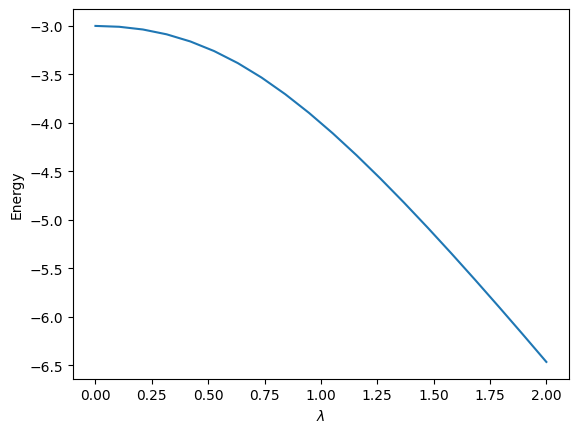

In [6]:
# Define number of spins
num_spins = 3

# 2x2 Pauli Matrices
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1,0],[0,-1]])

# Computing the term for nearest neighbours
H_nn = np.zeros((2**num_spins,2**num_spins))
for i in range(num_spins):
    # Generate a list of the x gate between nearest neighbours and identities everywhere else,
    # with special cases for the first and last
    if i == 0:
        H_nn_term_list = [ sigma_x, sigma_x, np.eye(2**(num_spins-2-i))]
    elif i == num_spins-1:
        H_nn_term_list = [ sigma_x, np.eye(2**(num_spins-2)), sigma_x]
    else:
        if num_spins-2-i==0:
            H_nn_term_list = [np.eye(2**i), sigma_x, sigma_x]
        else:
            H_nn_term_list = [np.eye(2**i), sigma_x, sigma_x, np.eye(2**(num_spins-2-i))]
    
    # print(f"\n\nMatrices for i={i}")
    # for term in H_nn_term_list:
        # print(term)

    # Multiple tensor product
    H_nn_term = mult_kron(H_nn_term_list)
    H_nn -= H_nn_term

lambda_vals = np.linspace(0,2,20)
energy_vals = []
for Lambda in lambda_vals:
    # Similar to the nearest neighbours case, construct the single spin part
    H_lambda = np.zeros((2**num_spins,2**num_spins))
    for i in range(num_spins):
        if i == 0:
            H_lambda_term_list = [ sigma_z, np.eye(2**(num_spins-1-i))]
        elif i == num_spins-1:
            H_lambda_term_list = [ np.eye(2**(num_spins-1)), sigma_z]
        else:
            H_lambda_term_list = [ np.eye(2**i), sigma_z, np.eye(2**(num_spins-1-i))]
        H_lambda_term = mult_kron(H_lambda_term_list)
        H_lambda += Lambda * H_lambda_term
    
    # Compute full hamiltonian
    H = H_nn + H_lambda

    # Calculate Ground State Energy and append
    eigvals, _ = la.eigh(H)
    energy_vals.append(eigvals[0])

plt.plot(lambda_vals,energy_vals)
plt.ylabel("Energy")
plt.xlabel(r"$\lambda$")
plt.show()

## Increasing the size
We now move to the generic $N$ we do it recursively notice that going from $n-1$ to $n$ you need to perform a simple step, 
1. first you build the Hamiltonian for $n-1$ spins, all the terms acting on the $n-1$ spins should be already summed as the Hamiltonian of the previous size, 
2. to be considered as terms of the Hamiltonian on the current size they need to be supplemented with the appropriate identity on the new spin,
3. then you add the new terms that involve the interaction with the new spin, which obviousbly need to be complemented with the identities acting on all the other spins which do not participate to the interaction,
4. finally you add the term that involves only the new spin.
5. Pay specific attention to boundary conditions, if you have a term that connects the first and last spin you need to add it only when you are at final size $N$, as a result you need to implement a sequence of Hamitlonians with open boundary conditions for every $n<N$  until you reach size $N$ and only at that point you add the term that connects the first and last spin.

Wrap the above code into the function by using the 

def function():
return 

statements, we want to provide, $N$ and $\lambda$ as arguments and obtain the energies, the eigenvectors and the Hamiltonian as a result of our function evaluation


In [7]:
def get_energy_from_system(num_spins:int, Lambda:float):
    # 2x2 Pauli Matrices
    sigma_x = np.array([[0,1],[1,0]])
    sigma_z = np.array([[1,0],[0,-1]])
    
    H_nn = np.zeros((2**num_spins,2**num_spins))
    H_lambda = np.zeros((2**num_spins,2**num_spins))

    for i in range(num_spins):
        if i == 0:
            H_nn_term_list = [ sigma_x, sigma_x, np.eye(2**(num_spins-2-i))]
            H_lambda_term_list = [ sigma_z, np.eye(2**(num_spins-1-i))]
        elif i == num_spins-1:
            H_nn_term_list = [ sigma_x, np.eye(2**(num_spins-2)), sigma_x]
            H_lambda_term_list = [ np.eye(2**(num_spins-1)), sigma_z]
        else:
            H_lambda_term_list = [ np.eye(2**i), sigma_z, np.eye(2**(num_spins-1-i))]
            if num_spins-2-i==0:
                H_nn_term_list = [np.eye(2**i), sigma_x, sigma_x]
            else:
                H_nn_term_list = [np.eye(2**i), sigma_x, sigma_x, np.eye(2**(num_spins-2-i))]

        H_nn_term = mult_kron(H_nn_term_list)
        H_nn -= H_nn_term

        H_lambda_term = mult_kron(H_lambda_term_list)
        H_lambda += Lambda * H_lambda_term
        
    # Compute full hamiltonian
    H = H_nn + H_lambda
    eigvals, eigvecs = la.eigh(H)
    return H, eigvals, eigvecs

## The spectral flow
Now in the following we use the function just defined to see the first 10 energy levels of the spectrum for several values of the field for fixed $N=10$. Keep in mind that the size of the Hamiltonian grows exponentially with $N$, so be careful not to go too high in size.
Plot the first 10 energy levels as a function of $\lambda$ in the interval $[0,10]$

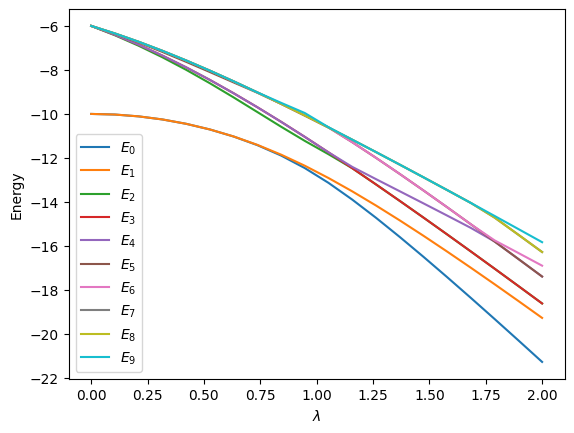

In [8]:
lambda_vals = np.linspace(0,2,20)
energy_spectrum = []

for Lambda in lambda_vals:
    _, spectrum, _ = get_energy_from_system(10,Lambda)
    energy_spectrum.append(spectrum[:10])
energy_spectrum = np.array(energy_spectrum)
for e,energy_level in enumerate(energy_spectrum.T):
    plt.plot(lambda_vals, energy_level, label=f"$E_{e}$")
plt.ylabel("Energy")
plt.xlabel(r"$\lambda$")
plt.legend()
plt.show()

The previous plot contains a lot of information, First of all you can clearly see that on the extreme left, eigenvalues organize in bands, separated by a gap. For the size value we consider the second and third band start to merge at around $\lambda= 0.5$. The first and the second band are still well separated, thought we observe that something happens in the first band at around $\lambda=1$. The two energy leves that constitute that band, start to separate..... 
This is a hint of the presence of a quantum phase transition, that breaks the symmetry of the system. Furthermore, if you look at the gap between the first and the second band, we see that around $\lambda=1$ this gaps is minimal...
 We will further analyze such a phenomenon in the next section

## Entanglement

We now focus on the entanglement of a bipartition of the system in two halves, for that we need to get the spectrum of 
$$
\rho_A = tr_B|\psi\rangle \langle \psi |_{AB}
$$
and its spectrum.

Equivalently remebering the relation between eigenvalue and singular value one can construc the spectrum of the singular value obtained by reshaping the vector to a matrix made by the legs in $A$ vs the legs in $B$. Indeed if we have the svd of the wavefunction reshaped as a matrix $M$ as
$$
M = U S V^{\dagger}
$$ 
then the reduced density matrix is given by
$$
\rho_A = M M^{\dagger} = U S V^{\dagger} V S^{\dagger} U^{\dagger} = U S^2 U^{\dagger}
$$

Since $A$ and $B$ are half of the system, it means that we want to reshape a vector of size $2^N$ into a matrix of size 
$2^N/2 \times 2^N/2$. That is the matrix we want the svd of.    

You can use the function np.reshape to reshape the vector into a matrix, and then use np.linalg.svd to compute its singular value decomposition.

Finally the eigenvector of $\rho$, $\lambda_i = s_i^2$ with $s_i$ one of the svds. 


Finally the entanglement entropy is computed by 
$$S= -\sum_i\left( \lambda_i \log(\lambda_i)\right)$$

Here you can use np.log to compute the logarithm. Be careful with the case $\lambda_i=0$ you can either filter them out before computing the entropy or add a small cutoff to avoid log(0).

You should compute it for different system sizes $N$ and produce a plot of $S$ vs $N$. 

How does it look like as a function of $N$? 

Can you compare it with the one for random states seen in class?


Rember that the Hamiltonian $H$ depends on a parameter, check different values of the parameter, does the entropy change?

In [ ]:
# Complete the code here as per the instructions provided above.

Try to run the above  code for different values of $\lambda$, do you see any difference? in how does the functional form of the entropy dependence on $N$ changes as we move  $\lambda$?



In [ ]:
# Complete the code here as per the instructions provided above.

# OPTIONAL: Constructing the full, symmetry resolved dispersion relation
We have now considered the ground state, but if we want to understand more we might want to examine the full low energy spectrum of the Hamiltonian. We will do this by constructing two other operators, the momentum and the charge, and diagonalize the three at the same time. We will also do this in two different points of the phase diagram in order to appreciate the difference. 

## Extracting the momentum on a ring.
Now we can build the translation operator, that cyclically permutes all the spins along the chain:
    
it sends spins $1,2 \cdots N-1, N$ into  $N, 1,2 \cdots N-1$

Again we want to create it iteratively starting from $N=2$, notice the simple recursion relation,


In [ ]:
# Complete the code here as per the instructions provided above.

Plot the eigenvalues on the complex plane, how do they look like?

In [ ]:
# Complete the code here as per the instructions provided above.

From the plot we appreciate that they look like phases, whose logarithm is exactly the momentum we are looking for, given that $T= exp(-i K)$ where $K$ is the momentum operator we are looking for. 

## Extracting the charge
Now we build a symmetry operator $S$ which is it? (Hint it is a product of Pauli matrices that needs to commute with the Hamiltonian whose eigenvalue gives the charge of the state).
Check that the translation operator, the symmetry operator and the Hamiltonian commute.

In [ ]:
# Complete the code here as per the instructions provided above.

Check that the symmetry operators has only eigenvalue $\pm 1$

In [ ]:
# Complete the code here as per the instructions provided above.

Now we want to obtain the simultaneous eigenvectors for all three operators  we want to get the spectrum with the three quantum numbers
$|e, k , s\rangle$

$ H|e, k , s\rangle = e |e, k , s\rangle$

$ T|e, k , s\rangle = \exp(ik) |e, k , s\rangle$

$ S|e, k , s\rangle = (-1)^s |e, k , s\rangle$

The trick is to construct a linear combination of the three operators.
You want to build the combination in such a way that the order of the eigenvalues of H is still respected and the other operators are only used to break the degeneracy

e.g for $N=10$ 
$O = H +0.01*T+ 0.001*S$

We only want the first eigenvectors so we will use Lanczos, that is implement in https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html

Now we have to reconstruct the three eigenvalues we are interested in by using the matrix element of the operator in the desired eigenvealue

$e = \langle e, k , s |H |e, k , s\rangle$

$\exp (i k ) = \langle e, k , s |T |e, k , s\rangle$


$s =  \langle e, k , s |S|e, k , s\rangle$


also since we are interested in $k$ we take the phase of the complex number $\exp(ik)$ using the  cmath.phase() function, remember to import cmath,


Finally we plot all the above information in a dispersion relation, a plot of the Energy  ($e$) versus the momentum ($k$), and use different symbols for different symmetry charges. 

Now we can start analyzing properties of the Hamiltonian. 
Let's first run the full code for $N=8$ and $N =12$ at $\lambda =1$. 



In [ ]:
# Complete the code here as per the instructions provided above.

Can you spot the difference? How does the level spacing changes when $N$ increases?

Now compare with similar plots for $\lambda=0.1$

In [ ]:
# Complete the code here as per the instructions provided above.